In [1]:
import pandas as pd
import numpy as np
import anndata as ad

t = !pwd
t = t[0]
%cd /mnt/win1/
from DeepSIST import benchmarking
%cd $t

/mnt/win1
/mnt/win1/DeepSIST_Notebook/MouseEmbryo_SSV2/SI_Benchmarking


# Load

In [4]:
adata = ad.read_h5ad('../../Dataset/AdataEmbryo1.h5ad')
adata.var_names_make_unique()

Y = adata.obs[['xcoord', 'ycoord']].values

In [5]:
pct_offset = 0

def MinMaxNorm(Y, Y_ref = Y):
    return (Y-Y_ref.min(axis = 0))/(Y_ref.max(axis = 0)-Y_ref.min(axis = 0))/(1+pct_offset)

def ReMMNorm(Y, Y_pred):
    return (Y_pred*(Y.max(axis=0)-Y.min(axis=0)*(1+pct_offset))+Y.min(axis = 0))

def PolarTrans(Y):
    
    R = np.sqrt(np.square(Y[:,0]) + np.square(Y[:,1]))
    Theta = np.arctan(Y[:,1]/Y[:,0])
    RTheta = np.concatenate([R.reshape(-1,1), Theta.reshape(-1,1)], axis = 1)
    
    return RTheta

def RePolarTrans(RTheta):
    x = RTheta[:,0] * np.cos(RTheta[:,1])
    y = RTheta[:,0] * np.sin(RTheta[:,1])
    Y = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)], axis = 1)
    return Y

In [6]:
RTheta = PolarTrans(Y)
YNorm = MinMaxNorm(Y)

train_indices = []
test_indices = []

for i in range(5):
    train_index = pd.read_csv('../CV_groups/index_train_' + str(i+1) + '.csv',
                              header = None, index_col = 0).values.flatten()
    test_index = pd.read_csv('../CV_groups/index_test_' + str(i+1) + '.csv',
                             header = None, index_col = 0).values.flatten()
    train_indices.append(train_index)
    test_indices.append(test_index)

In [ ]:
SpaOTscs = []
novosparcs = []
DSs = []
LRs = []
Tangrams = []

#Preprocess (format transform and normalize)
for i in range(5):
    
    Tangram = pd.read_csv('Tangram/pred_' + str(i) + '.csv').values
    SpaOTsc = pd.read_csv('SpaOTsc/pred_' + str(i) + '.csv').values
    novosparc = pd.read_csv('novosparc/pred_' + str(i) + '.csv').values
    DS = pd.read_csv('DeepSIST/pred_' + str(i) + '.csv', header = None, index_col = 0).values
    LR = pd.read_csv('LR/pred_' + str(i) + '.csv', header = None, index_col = 0).values

    #Normalize
    DS = MinMaxNorm( RePolarTrans(ReMMNorm(RTheta, DS)), Y_ref = Y)
    LR = MinMaxNorm( RePolarTrans(ReMMNorm(RTheta, LR)), Y_ref = Y)
    novosparc = MinMaxNorm(novosparc, Y_ref = Y)
    SpaOTsc = MinMaxNorm(SpaOTsc, Y_ref = Y)
    Tangram = MinMaxNorm(Tangram, Y_ref = Y)

    Tangrams.append(Tangram)
    SpaOTscs.append(SpaOTsc)
    novosparcs.append(novosparc)
    DSs.append(DS)
    LRs.append(LR)

In [5]:
def evaluate(pred, Y_true):

    pearsonr_x = stats.pearsonr(Y_true[:, 0], pred[:, 0])[0]
    pearsonr_y = stats.pearsonr(Y_true[:, 1], pred[:, 1])[0]
    rmse = np.sqrt(np.square(Y_true - pred).sum() / Y_true.shape[0])
    r2 = r2_score(Y_true, pred, multioutput='variance_weighted')
    
    return [pearsonr_x, pearsonr_y, rmse, r2]

def eval_cv(preds):
    
    performances = []

    for i in range(5):
        performance = evaluate(pred = preds[i],
                               Y_true = YNorm[test_indices[i]])
        performances.append(performance)

    performances = pd.DataFrame(performances,
                                columns = ['pearsonr_x', 'pearsonr_y', 'MSE', 'R2'])
    
    return performances

In [6]:
Tangram_performance = eval_cv(Tangrams)
SpaOTsc_performance = eval_cv(SpaOTscs)
novo_performance = eval_cv(novosparcs)
SILE_performance = eval_cv(SILEs)
LR_performance = eval_cv(LRs)

In [7]:
SILE_performance

,pearsonr_x,pearsonr_y,MSE,R2
0,0.922894,0.859375,0.154998,0.791970
1,0.917218,0.855379,0.157358,0.785103
2,0.923820,0.856997,0.155118,0.793965
3,0.920081,0.863623,0.155257,0.793918
4,0.929290,0.871754,0.148413,0.808238


In [8]:
novo_performance

,pearsonr_x,pearsonr_y,MSE,R2
0,0.601430,0.635751,0.303221,0.203855
1,0.586643,0.638762,0.303676,0.199655
2,0.594405,0.640552,0.305535,0.200649
3,0.592706,0.636372,0.305919,0.199886
4,0.589893,0.641730,0.303187,0.199725


In [9]:
SpaOTsc_performance

,pearsonr_x,pearsonr_y,MSE,R2
0,0.592090,0.389971,0.312319,0.155361
1,0.586576,0.394140,0.311677,0.156925
2,0.592461,0.409887,0.314058,0.155431
3,0.601182,0.400276,0.314266,0.155628
4,0.590457,0.400042,0.310679,0.159681


In [10]:
LR_performance 

,pearsonr_x,pearsonr_y,MSE,R2
0,0.677757,0.557007,0.320024,0.113174
1,0.662825,0.545875,0.328952,0.060879
2,0.661963,0.535644,0.330678,0.063673
3,0.657434,0.544728,0.329696,0.070679
4,0.658684,0.543577,0.328788,0.058869


In [11]:
Benchmark = pd.DataFrame([SILE_performance.mean().tolist(),
                          novo_performance.mean().tolist(),
                          SpaOTsc_performance.mean().tolist(),
                          LR_performance.mean().tolist()],
                          columns=['pearsonr_x', 'pearsonr_y', 'RMSE', 'R2'],
                          index = ['SILE', 'Novosparc', 'SpaOTsc', 'LR'])
for column in Benchmark.columns:
    Benchmark[column] = Benchmark[column].apply('{:,.3f}'.format)
Benchmark.to_csv('Benchmark.csv', header = True, index = True)
Benchmark

,pearsonr_x,pearsonr_y,RMSE,R2
SILE,0.923,0.861,0.154,0.795
Novosparc,0.593,0.639,0.304,0.201
SpaOTsc,0.593,0.399,0.313,0.157
LR,0.664,0.545,0.328,0.073


# Visualization

In [6]:
adata = ad.read_h5ad('../AdataEmbryo1.h5ad')
adata.var_names_make_unique()

Anno = pd.read_csv('../slideSeq_Puck190926_03_RCTD.csv', index_col = 0)

Anno['MCT'] = 't'

index1 = Anno.index[(Anno['celltype_1'] == Anno['celltype_2'])]
Anno['MCT'][index1] = Anno['celltype_1'][index1]
index2 = Anno.index[(Anno['celltype_1'] != Anno['celltype_2'])]
Anno['MCT'][index2] = (Anno['celltype_1'][index2] + '_' + Anno['celltype_2'][index2]).apply(lambda x: '_'.join(sorted(set(x.split('_')))))

adata.obs = adata.obs.merge(Anno, left_index = True, right_index = True, how = 'left')
adata.obs

,xcoord,ycoord,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ERCC,pct_counts_ERCC,leiden,spot_class,celltype_1,celltype_2,MCT
barcodes,,,,,,,,,,,,,,
TTCAATTCTCGCTT,2113.1,5092.7,2180,2180,3405.0,108.0,3.171806,2.0,0.058737,7,doublet_uncertain,My,Sc,My_Sc
TTTCTGTGCAGACC,2112.9,4926.6,2240,2240,3483.0,82.0,2.354292,1.0,0.028711,4,singlet,Sc,Sc,Sc
TTTCACAGCGACGT,1789.3,4874.1,2047,2047,3149.0,37.0,1.174976,0.0,0.000000,7,doublet_uncertain,My,Sc,My_Sc
CTCTGGCCTCGCTT,3120.3,5450.9,2171,2169,3245.0,47.0,1.448382,0.0,0.000000,4,doublet_certain,Sc,PEL,PEL_Sc
AACGGCGTCAGGCA,2020.0,3519.0,1901,1901,3159.0,73.0,2.310858,0.0,0.000000,2,doublet_certain,H,PEL,H_PEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCACCGTGTCCGAT,3266.0,4534.7,271,271,293.0,4.0,1.365188,0.0,0.000000,0,reject,Sc,PEL,PEL_Sc
GTAAAAGTAGCTCT,3769.0,3363.3,211,211,226.0,0.0,0.000000,0.0,0.000000,6,reject,Sc,Mg,Mg_Sc
ACCGGTGCGCCTCC,3255.7,3152.7,242,242,254.0,3.0,1.181102,0.0,0.000000,0,reject,Sc,En,En_Sc


In [8]:
def Visualize1(adata, coord, cname = 'MCT', anchor = (1, 0.9),
               xlim = [650, 5750], ylim = [650, 5750], lim = True,
               title = 'SILE', legend = True):
    
    save = 'figures_SI/'
    if not os.path.exists(save):
        os.makedirs(save)
    
    CTs = adata.obs[cname].value_counts()
    is_doub = CTs.index.str.contains('_')

    SelectedCTs = CTs[~is_doub].index.tolist()[:8]
    #SelectedCTs = CTs.index.tolist()[:8]

    t = adata
    Select1 = t.obs[cname].apply(lambda x: x in SelectedCTs)
    Select = Select1
    
    t = t[Select]
    coord = coord[Select]

    color_dic = {}
    for i, ct in enumerate(t.obs[cname].unique()):
        color_dic[ct] = i

    color = list(map(lambda x: color_dic[x], t.obs[cname]))

    plt.figure(figsize =(7,6))
    scatter = plt.scatter(coord[:, 0],\
                coord[:, 1],\
                s = 3,\
                c = color,\
                cmap = plt.get_cmap('Paired'))
    plt.grid(False)
    
    if(lim):
        plt.xlim([650, 5750])
        plt.ylim([650, 5750])
    
    if(legend):
        plt.title(title)
        plt.legend(handles=scatter.legend_elements()[0],
                   labels = list(t.obs[cname].unique()),
                   bbox_to_anchor=anchor)
        plt.savefig(save + title + '_1.png', bbox_inches='tight')
    else:
        plt.savefig(save + title + '_1_no_legend.png', bbox_inches='tight')
    plt.show()

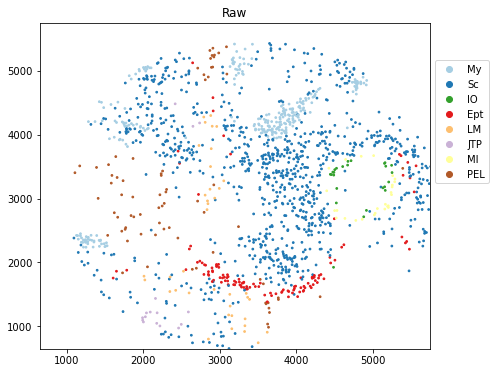

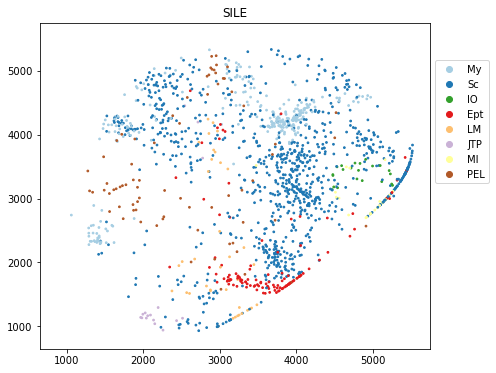

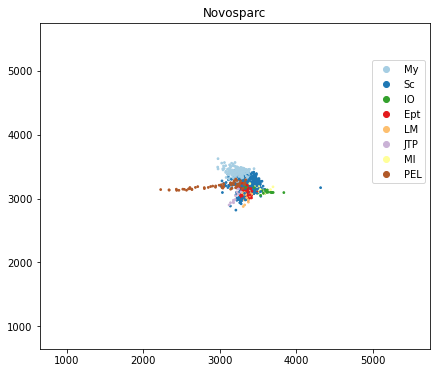

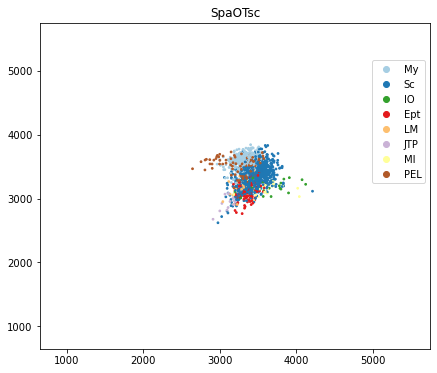

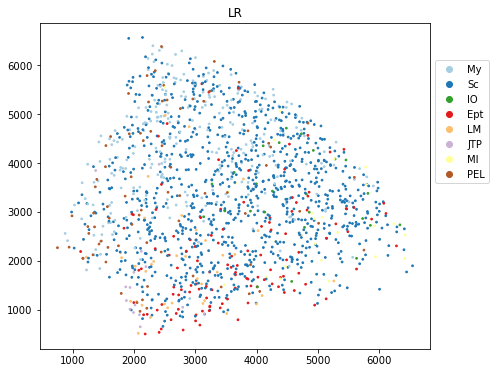

In [17]:
i = 0
index = test_indices[i]
Visualize1(adata = adata[index], coord = Y[index], title = 'Raw')

SILE = pd.read_csv('SILE/pred_' + str(i) + '.csv', header = None, index_col = 0).values
SILE = RePolarTrans(ReMMNorm(RTheta, SILE))
Visualize1(adata = adata[index], coord = SILE, title = 'SILE')

novosparc = np.load('novosparc/pred_full_' + str(i) + '.npy')
novosparc = np.matmul(novosparc, Y[train_indices[i]]) * novosparc.shape[0]
Visualize1(adata = adata[index], coord = novosparc, title = 'Novosparc')

SpaOTsc = np.load('SpaOTsc/pred_' + str(i) + '.npy')
SpaOTsc = np.matmul(SpaOTsc, Y[train_indices[i]]) * SpaOTsc.shape[0]
Visualize1(adata = adata[index], coord = SpaOTsc, title = 'SpaOTsc')

LR = pd.read_csv('LR/pred_' + str(i) + '.csv', header = None, index_col = 0).values
LR = RePolarTrans(ReMMNorm(RTheta, LR))
Visualize1(adata = adata[index], coord = LR, lim = False, title = 'LR')

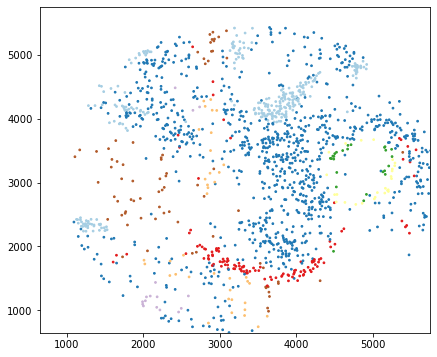

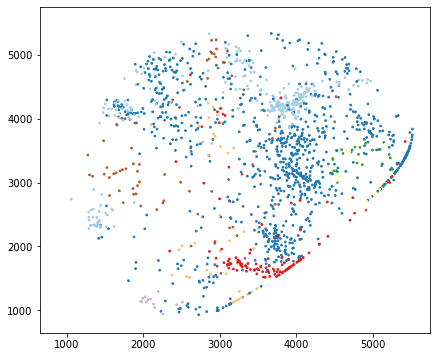

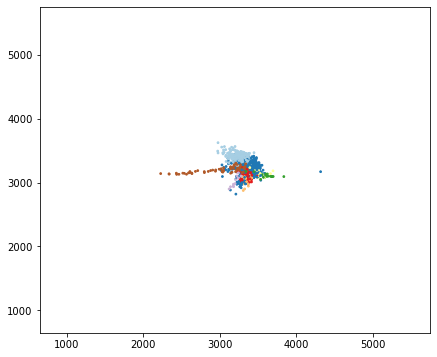

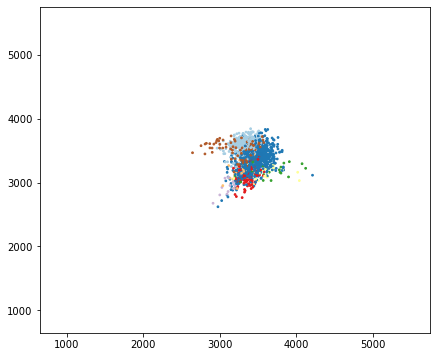

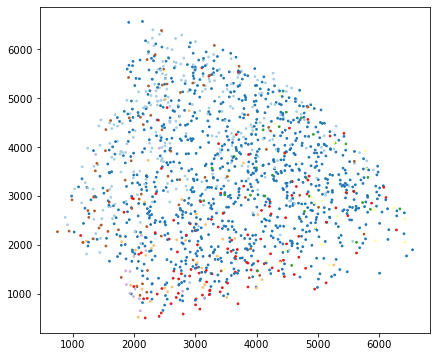

In [9]:
i = 0
index = test_indices[i]
legend = False

Visualize1(adata = adata[index], coord = Y[index], title = 'Raw', legend = legend)

SILE = pd.read_csv('SILE/pred_' + str(i) + '.csv', header = None, index_col = 0).values
SILE = RePolarTrans(ReMMNorm(RTheta, SILE))
Visualize1(adata = adata[index], coord = SILE, title = 'SILE', legend = legend)

novosparc = np.load('novosparc/pred_full_' + str(i) + '.npy')
novosparc = np.matmul(novosparc, Y[train_indices[i]]) * novosparc.shape[0]
Visualize1(adata = adata[index], coord = novosparc, title = 'Novosparc', legend = legend)

SpaOTsc = np.load('SpaOTsc/pred_' + str(i) + '.npy')
SpaOTsc = np.matmul(SpaOTsc, Y[train_indices[i]]) * SpaOTsc.shape[0]
Visualize1(adata = adata[index], coord = SpaOTsc, title = 'SpaOTsc', legend = legend)

LR = pd.read_csv('LR/pred_' + str(i) + '.csv', header = None, index_col = 0).values
LR = RePolarTrans(ReMMNorm(RTheta, LR))
Visualize1(adata = adata[index], coord = LR, lim = False, title = 'LR', legend = legend)